In [1]:
# Setup (Imports)

from LoadData import *

from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import Dense, LSTM, Dropout, BatchNormalization, Activation

import numpy as np

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Setup (Globals/Hyperz)

window_size = 44
window_skip = 4
epochs      = 1000
batch_size  = 128

In [3]:
# Loading and Splitting Data

def get_data(stock, variation='mlp-regression'):
    """
    Gets data from `stock` for specific `variation` model
    """
    if variation == 'lstm-regression':
        
        AllX, AllY = create_timeframed_close_regression_data(stock, window_size, window_skip, norm=True)
    
        trainX, trainY, testX, testY = split_data(AllX, AllY, ratio=.9)

        trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
        testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
        
    elif variation == 'mlp-regression':
        
        AllX, AllY = create_timeframed_close_regression_data(stock, window_size, window_skip, norm=True)
    
        trainX, trainY, testX, testY = split_data(AllX, AllY, ratio=.9)
    
    return (trainX, trainY), (testX, testY)


In [4]:
# Setup (Create Model)

def get_model(variation='mlp-regression'):
    """
    Gets the model for specific `variation`
    """
    if variation == 'lstm-regression':

        model = Sequential()

        model.add(LSTM(16, input_shape=(1, window_size - window_skip), return_sequences=True))

        model.add(LSTM(16, return_sequences=False))

        model.add(Dense(10, activation='relu'))

        model.add(Dense(1, activation='linear'))

        model.compile(loss='mse', optimizer='adam')
        
    elif variation == 'mlp-regression':
        
        model = Sequential()

        model.add(Dense(100, input_dim=window_size - window_skip))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(.25))
        
        model.add(Dense(100))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(.25))
        
        model.add(Dense(30))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(.25))
        
        model.add(Dense(1, activation='linear'))

        model.compile(loss='mse', optimizer='adam')
        
    return model


In [5]:
# Run (Load)

if __name__ == "__main__":

    (trainX, trainY), (testX, testY) = get_data('AAPL', variation='mlp-regression')

    print(trainX.shape, trainY.shape)


(3969, 40) (3969,)


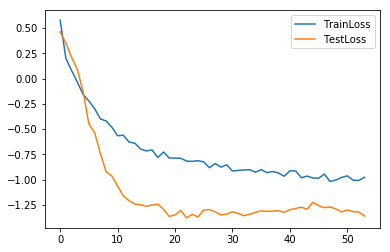

In [6]:
# Run (Train)

if __name__ == "__main__":

    model = get_model(variation='mlp-regression')

    history = model.fit(trainX, trainY, epochs=epochs, 
                                        batch_size=batch_size, 
                                        validation_data=(testX, testY), 
                                        verbose=0, 
                                        callbacks=[EarlyStopping(patience=30)])

    plt.plot(np.log(history.history['loss']))
    plt.plot(np.log(history.history['val_loss']))
    plt.legend(['TrainLoss', 'TestLoss'])
    plt.show()
    
    model.save(os.path.join('models', 'basic-regression.h5'))


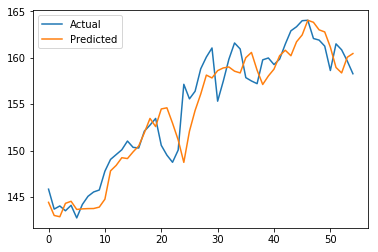

In [9]:
# Test

if __name__ == "__main__":

    data = csv_as_numpy('AAPL')[1][:, 3]

    data = data[-100:]

    prices_actual = []
    prices_predicted = []

    for i in range(len(data) - window_size - 1):
        
        time_frame = np.copy(data[i: i + window_size + 1])
            
        mean = np.mean(time_frame[:-1])
            
        time_frame -= mean
            
        std = np.std(time_frame)
            
        time_frame /= std
    
        X = np.array([time_frame[:-1 - window_skip]])
    
        prediction = model.predict(X)
    
        # prediction = model.predict(np.reshape(X, (X.shape[0], 1, X.shape[1])))
    
        prediction = np.squeeze(prediction) * std + mean
    
        prices_actual.append(data[i + window_size])
        prices_predicted.append(prediction)

    plt.plot(prices_actual)
    plt.plot(prices_predicted)
    plt.legend(['Actual', 'Predicted'])
    plt.show()
